# Transformer Multi-Output Regression for NBA Player Statistics

This notebook implements a transformer-based multi-output regression pipeline for predicting NBA player statistics, following the same structure as the LSTM, regression, Bayesian, and tree model notebooks.

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import joblib
import matplotlib.pyplot as plt
import random

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Data Loading and Preprocessing

In [2]:
csv_dir = os.path.join('..', 'CSVs') if not os.path.exists('train_season_features.csv') else '.'
models_dir = os.path.join('..', 'Models') if not os.path.exists('Models') else 'Models'
os.makedirs(models_dir, exist_ok=True)

train = pd.read_csv(os.path.join(csv_dir, 'train_season_features.csv'))
test = pd.read_csv(os.path.join(csv_dir, 'test_season_features.csv'))

target_cols = [c for c in train.columns if c.startswith('next_')]
feature_cols = [c for c in train.columns if c not in ['PERSON_ID', 'SEASON_ID'] + target_cols]

X_train, X_val, y_train, y_val = train_test_split(
    train[feature_cols], train[target_cols], test_size=0.2, random_state=SEED
)
X_test, y_test = test[feature_cols], test[target_cols]

# Handle infinite values
for df_ in [X_train, X_val, y_train, y_val, X_test, y_test]:
    df_.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute missing values
imputer_X = SimpleImputer(strategy='median')
imputer_y = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(imputer_X.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_imputed = pd.DataFrame(imputer_X.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_imputed = pd.DataFrame(imputer_X.transform(X_test), columns=X_test.columns, index=X_test.index)
y_train_imputed = pd.DataFrame(imputer_y.fit_transform(y_train), columns=y_train.columns, index=y_train.index)
y_val_imputed = pd.DataFrame(imputer_y.transform(y_val), columns=y_val.columns, index=y_val.index)
y_test_imputed = pd.DataFrame(imputer_y.transform(y_test), columns=y_test.columns, index=y_test.index)

# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train_imputed.columns, index=X_train_imputed.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_imputed), columns=X_val_imputed.columns, index=X_val_imputed.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_test_imputed.columns, index=X_test_imputed.index)

# Convert to numpy arrays
X_train_array = X_train_scaled.values
y_train_array = y_train_imputed.values
X_val_array = X_val_scaled.values
y_val_array = y_val_imputed.values
X_test_array = X_test_scaled.values
y_test_array = y_test_imputed.values

n_features = X_train_array.shape[1]
n_targets = y_train_array.shape[1]
n_samples = X_train_array.shape[0]
print(f'Training samples: {n_samples}, Features: {n_features}, Targets: {n_targets}')

Training samples: 1529, Features: 56, Targets: 21


/var/folders/8z/yxhm1c6x4bvg_s6d6w0cl6_80000gn/T/ipykernel_30804/2896745583.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_.replace([np.inf, -np.inf], np.nan, inplace=True)


## Transformer Model Definition

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=128, nhead=8, num_layers=4, dim_feedforward=256, dropout=0.2, seq_len=10):
        super().__init__()
        self.input_linear = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, output_dim)
    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        x = self.input_linear(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x[:, -1, :]  # Use last time step
        x = self.dropout(x)
        x = self.fc(x)
        return x

## Sequence Preparation

In [4]:
def create_sequences(X, y, sequence_length=10):
    X_seq, y_seq = [], []
    for i in range(sequence_length, len(X)):
        X_seq.append(X[i-sequence_length:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 10
X_train_seq, y_train_seq = create_sequences(X_train_array, y_train_array, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val_array, y_val_array, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_array, y_test_array, sequence_length)

X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)

batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Model Instantiation

In [5]:
d_model = 128
nhead = 8
num_layers = 4
dim_feedforward = 256
dropout = 0.2
model = TransformerRegressor(
    input_dim=n_features,
    output_dim=n_targets,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    seq_len=sequence_length
).to(device)
print(model)

TransformerRegressor(
  (input_linear): Linear(in_features=56, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=21, bias=True)
)


## Training Setup

In [6]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
num_epochs = 200
patience = 50
best_val_loss = float('inf')
patience_counter = 0
train_losses, val_losses = [], []

## Training Loop with Early Stopping and Gradient Clipping

In [7]:
print('Starting training...')
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_train_loss += loss.item() * X_batch.size(0)
    train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_val_loss += loss.item() * X_batch.size(0)
    val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), os.path.join(models_dir, 'transformer_regression_best_model.pth'))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

model.load_state_dict(torch.load(os.path.join(models_dir, 'transformer_regression_best_model.pth')))
print('Training complete. Best model restored.')

Starting training...
Epoch 1/200 - Train Loss: 578.3921 - Val Loss: 537.0811
Epoch 2/200 - Train Loss: 532.8436 - Val Loss: 500.0303
Epoch 3/200 - Train Loss: 495.2177 - Val Loss: 462.1536
Epoch 4/200 - Train Loss: 456.0174 - Val Loss: 423.4533
Epoch 5/200 - Train Loss: 417.4665 - Val Loss: 384.9405
Epoch 6/200 - Train Loss: 378.8499 - Val Loss: 347.5045
Epoch 7/200 - Train Loss: 340.7769 - Val Loss: 311.2745
Epoch 8/200 - Train Loss: 304.7476 - Val Loss: 276.7727
Epoch 9/200 - Train Loss: 270.3856 - Val Loss: 244.3554
Epoch 10/200 - Train Loss: 238.2189 - Val Loss: 214.2399
Epoch 11/200 - Train Loss: 208.0992 - Val Loss: 186.4782
Epoch 12/200 - Train Loss: 181.6935 - Val Loss: 161.5616
Epoch 13/200 - Train Loss: 156.6270 - Val Loss: 139.1423
Epoch 14/200 - Train Loss: 134.8324 - Val Loss: 119.5371
Epoch 15/200 - Train Loss: 116.3522 - Val Loss: 102.5256
Epoch 16/200 - Train Loss: 99.6058 - Val Loss: 88.0097
Epoch 17/200 - Train Loss: 85.5056 - Val Loss: 75.5597
Epoch 18/200 - Train Lo

## Plot Training and Validation Loss

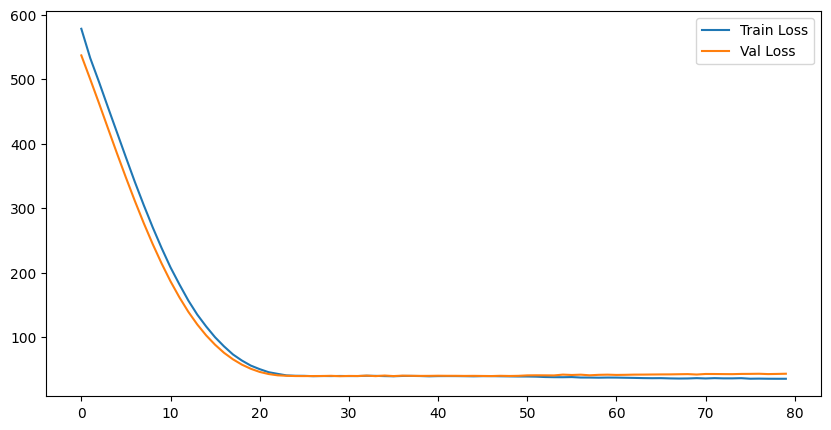

In [8]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

## Evaluation on Test Set

In [9]:
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        y_pred.append(outputs.cpu().numpy())
        y_true.append(y_batch.cpu().numpy())
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)

test_mae = mean_absolute_error(y_true, y_pred)
test_r2 = r2_score(y_true, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'Test MAE: {test_mae:.3f}')
print(f'Test R²: {test_r2:.3f}')
print(f'Test RMSE: {test_rmse:.3f}')

print('Per-target test metrics:')
for i, target_name in enumerate(target_cols):
    target_mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    target_r2 = r2_score(y_true[:, i], y_pred[:, i])
    print(f'{target_name}: MAE={target_mae:.3f}, R²={target_r2:.3f}')

Test MAE: 3.757
Test R²: -0.116
Test RMSE: 6.539
Per-target test metrics:
next_Points: MAE=6.317, R²=-0.171
next_FTM: MAE=1.362, R²=-0.190
next_FTA: MAE=1.686, R²=-0.229
next_FGM: MAE=2.226, R²=-0.146
next_FGA: MAE=4.647, R²=-0.159
next_TO: MAE=0.343, R²=-0.071
next_STL: MAE=0.346, R²=-0.187
next_BLK: MAE=0.736, R²=-0.088
next_PF: MAE=0.641, R²=-0.248
next_USAGE_RATE: MAE=9.793, R²=-0.024
next_OREB: MAE=0.562, R²=-0.010
next_DREB: MAE=1.637, R²=-0.198
next_AST: MAE=1.583, R²=-0.058
next_REB: MAE=2.101, R²=-0.154
next_Minutes: MAE=8.307, R²=-0.243
next_3PM: MAE=0.754, R²=-0.000
next_3PA: MAE=1.976, R²=-0.010
next_3P%: MAE=6.982, R²=-0.000
next_FT%: MAE=9.041, R²=-0.005
next_FG%: MAE=6.006, R²=-0.061
next_GAME_EFFICIENCY: MAE=11.855, R²=-0.190


## Prediction vs Actual Plots for a Few Targets

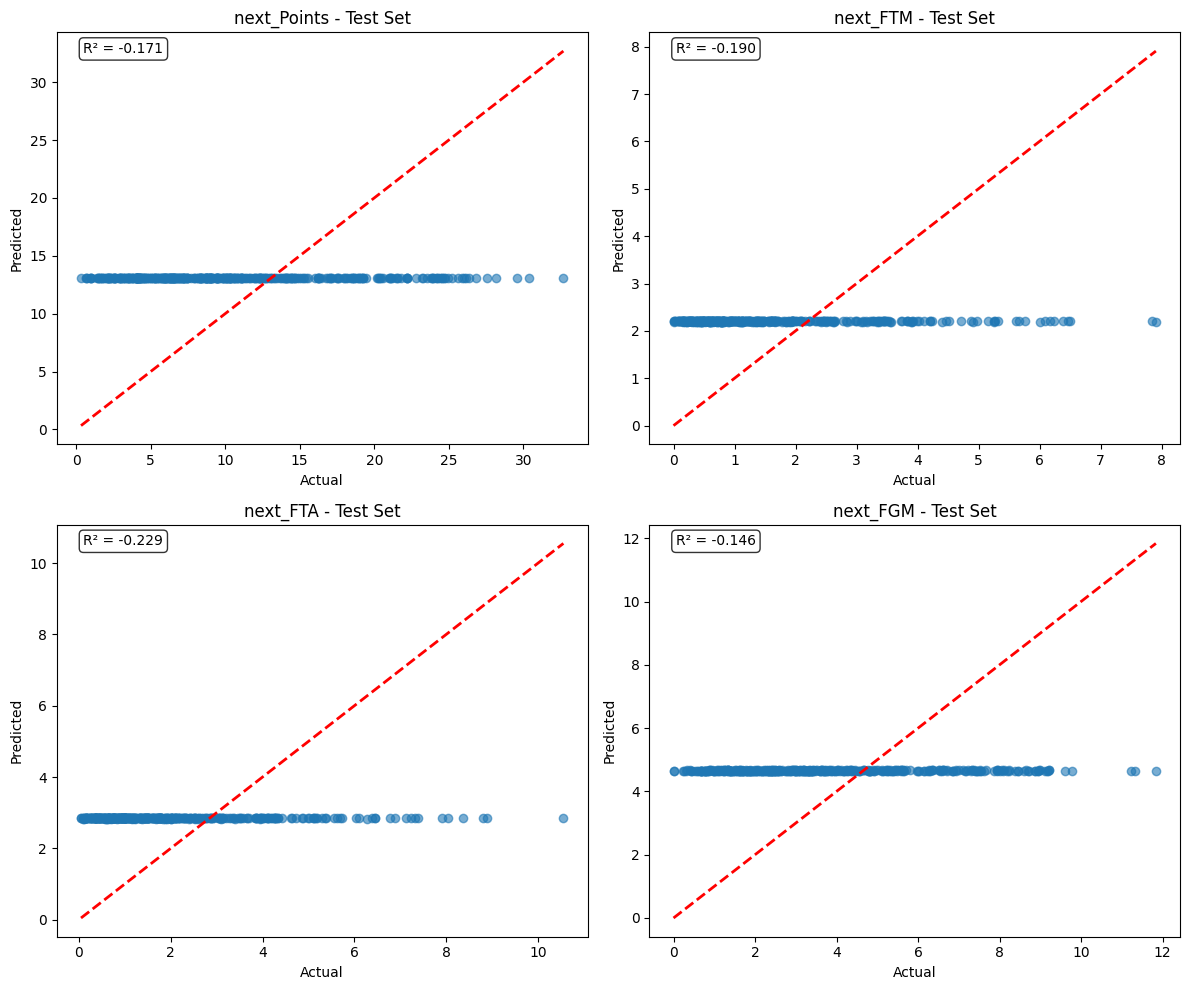

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
for i in range(4):
    axes[i].scatter(y_true[:, i], y_pred[:, i], alpha=0.6)
    axes[i].plot([y_true[:, i].min(), y_true[:, i].max()], [y_true[:, i].min(), y_true[:, i].max()], 'r--', lw=2)
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')
    axes[i].set_title(f'{target_cols[i]} - Test Set')
    r2 = r2_score(y_true[:, i], y_pred[:, i])
    axes[i].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[i].transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

## Save Model, Scalers, and Column Info

In [11]:
# Save model state dict with torch.save
torch.save(model.state_dict(), os.path.join(models_dir, 'transformer_regression_best_model.pth'))

# Save scaler and imputers with joblib
joblib.dump(scaler, os.path.join(models_dir, 'transformer_scaler.joblib'))
joblib.dump(imputer_X, os.path.join(models_dir, 'transformer_imputer_X.joblib'))
joblib.dump(imputer_y, os.path.join(models_dir, 'transformer_imputer_y.joblib'))

# Save columns info with joblib
columns_info = {
    'feature_cols': feature_cols,
    'target_cols': target_cols
}
joblib.dump(columns_info, os.path.join(models_dir, 'transformer_columns.joblib'))

print('All model components saved successfully!')


All model components saved successfully!


## Prediction Function for Inference

In [12]:
def predict_with_transformer_model(X, models_dir, sequence_length=10):
    """
    Predict NBA stats using a trained transformer regression model.

    Parameters:
        X (pd.DataFrame): Input features (must contain all required feature columns)
        models_dir (str): Path to model artifacts directory
        sequence_length (int): Sequence length expected by the model

    Returns:
        pd.DataFrame: Predictions for each target, aligned with X indices (offset by sequence_length)
    """
    import torch
    import joblib
    import numpy as np
    import pandas as pd
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # --- Load artifacts ---
    columns_info = joblib.load(os.path.join(models_dir, 'transformer_columns.joblib'))
    feature_cols = columns_info['feature_cols']
    target_cols = columns_info['target_cols']
    imputer_X = joblib.load(os.path.join(models_dir, 'transformer_imputer_X.joblib'))
    scaler = joblib.load(os.path.join(models_dir, 'transformer_scaler.joblib'))

    # Model hyperparameters (ensure these match your training config)
    d_model = 128
    nhead = 8
    num_layers = 4
    dim_feedforward = 256
    dropout = 0.2

    # --- Preprocess input ---
    X = X[feature_cols].copy()
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_imputed = pd.DataFrame(imputer_X.transform(X), columns=X.columns, index=X.index)
    X_scaled = scaler.transform(X_imputed)

    # --- Create sequences ---
    def create_sequences(X_arr, sequence_length):
        X_seq = []
        for i in range(sequence_length, len(X_arr)):
            X_seq.append(X_arr[i-sequence_length:i])
        return np.array(X_seq)
    X_seq = create_sequences(X_scaled, sequence_length)
    X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)

    # --- Load model and weights ---
    model = TransformerRegressor(
        input_dim=len(feature_cols),
        output_dim=len(target_cols),
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout,
        seq_len=sequence_length
    ).to(device)
    state_dict = torch.load(
        os.path.join(models_dir, 'transformer_regression_best_model.pth'),
        map_location=device,
        weights_only=False
    )
    model.load_state_dict(state_dict)
    model.eval()

    # --- Make predictions ---
    with torch.no_grad():
        preds = model(X_tensor).cpu().numpy()
    pred_df = pd.DataFrame(preds, columns=target_cols, index=X.index[sequence_length:])
    return pred_df


print('Prediction function ready.')
# Make predictions on validation set
print("Making predictions on validation set...")
val_predictions = predict_with_transformer_model(X_val_scaled, models_dir=models_dir, sequence_length=sequence_length)

print(f"Validation predictions shape: {val_predictions.shape}")



# Save the prediction function
prediction_func_path = os.path.join(models_dir, "transformer_prediction_function.joblib")
joblib.dump(predict_with_transformer_model, prediction_func_path)
print(f"Prediction function saved to: {prediction_func_path}")

print("\nTransformer model training completed!")

Prediction function ready.
Making predictions on validation set...
Validation predictions shape: (373, 21)
Prediction function saved to: ../Models/transformer_prediction_function.joblib

Transformer model training completed!
